### Helpers

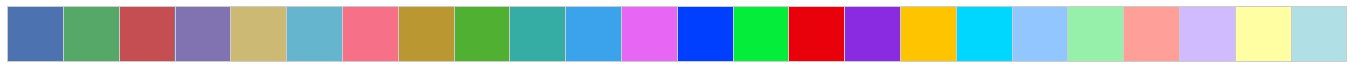

In [127]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
import utils
import scoring

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

In [128]:
def get_simple_features(data):
    return data.loc[:, utils.SIMPLE_FEATURE_COLUMNS]

x_cols = ['MatchedHit_X[%i]' % i for i in range(utils.N_STATIONS)]
y_cols = ['MatchedHit_Y[%i]' % i for i in range(utils.N_STATIONS)]
z_cols = ['MatchedHit_Z[%i]' % i for i in range(utils.N_STATIONS)]
        

### Reading

In [87]:
train_0 = pd.read_csv('data/train_part_1_v2.csv.gz', nrows=4000000, na_values='-9999.0')
test_0 = pd.read_csv('data/test_public_v2.csv.gz', na_values='-9999.0')

train_0.shape, test_0.shape

((2722852, 80), (726095, 75))

In [151]:
train = train_0
test = test_0

### Pipeline

In [148]:
import xgboost as xgb
from sklearn import model_selection as mdsel

def fit(train):
    target_train = train.loc[:, utils.TRAIN_COLUMNS]
    
    # defined much later
    transformer = DataTransformer().fit(train)
    train = transformer.transform(train)
    
    estimator = xgb.XGBClassifier(n_estimators=120, n_jobs=3)
    estimator.fit(train.values, target_train.label.values, sample_weight=target_train.weight.values)
    return transformer, estimator
    
def predict(fitted_state, test):
    transformer, estimator = fitted_state
    
    test = transformer.transform(test)
    predictions = estimator.predict_proba(test.values)[:, 1]
    return predictions

def score(fitted_state, test):
    target_test = test.loc[:, utils.TRAIN_COLUMNS]
    predictions = predict(fitted_state, test)
    score = scoring.rejection90(target_test.label.values, predictions, sample_weight=target_test.weight.values)
    return score

def fit_predict_save(train, test, filename):
    fitted_state = fit(train)
    predictions = predict(fitted_state, test)
    
    pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
        filename, index_label=utils.ID_COLUMN
    )
    
def cross_validate(train, n_splits, n_rows=1000):
    # сделать честную случайную подвыборку
    train = train.iloc[:n_rows, :]
    
    splitter = mdsel.StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = [
        score(fit(train.iloc[train_indices, :]), train.iloc[test_indices, :])
        for train_indices, test_indices in splitter.split(train, train.label)
    ]

    return pd.DataFrame(scores, columns=['Score'])

### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [149]:
from sklearn.base import TransformerMixin

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return get_simple_features(X)

### Test theory

In [154]:
%%time
df_scores = cross_validate(train, n_splits=5, n_rows=10000)
print(df_scores.describe())

          Score
count  5.000000
mean   0.588690
std    0.355089
min    0.275565
25%    0.386202
50%    0.470579
75%    0.631189
max    1.179915
Wall time: 7.15 s


### Get result

In [133]:
%%time
fit_predict_save(train, test, "out/02_baseline.csv")

Wall time: 4.97 s
